In [3]:
using Plots
using ForwardDiff
using LinearAlgebra
using QuadGK
using Test

In [31]:
include("src/plotters.jl")
include("src/linesearch.jl")
include("src/transform.jl")
include("src/projection.jl");
include("src/reparametrization.jl")

printfooter (generic function with 1 method)

## Test of Type Stability

In [5]:
# Define my test functions
c1(t) = [t, 0]
γopt(t) = 0.9t^2 + 0.1t
c2 = c1 ∘ γopt



# ... and their derivatives
c1dt(t) = ForwardDiff.derivative(c1, t)
c2dt(t) = ForwardDiff.derivative(c2, t)
γoptdt(t) = ForwardDiff.derivative(γopt, t)

γoptdt (generic function with 1 method)

In [6]:
# And get the q-maps of my test curves
q = Q_transform(c1)
r = Q_transform(c2)


∇E = l2_gradient(q, r)

#77 (generic function with 1 method)

In [7]:
@code_warntype c1(0.1)

Variables
  #self#::Core.Compiler.Const(c1, false)
  t::Float64

Body::Array{Float64,1}
1 ─ %1 = Base.vect(t, 0)::Array{Float64,1}
└──      return %1


In [8]:
@code_warntype c2(0.1)

Variables
  #self#::Core.Compiler.Const(Base.var"#62#63"{typeof(c1),typeof(γopt)}(c1, γopt), false)
  x::Tuple{Float64}

Body::Array{Float64,1}
1 ─ %1 = Core.getfield(#self#, :f)::Core.Compiler.Const(c1, false)
│   %2 = Core.getfield(#self#, :g)::Core.Compiler.Const(γopt, false)
│   %3 = Core._apply_iterate(Base.iterate, %2, x)::Float64
│   %4 = (%1)(%3)::Array{Float64,1}
└──      return %4


In [9]:
@code_warntype q(0.1)

Variables
  #self#::Core.Compiler.Const(var"#55#57"{typeof(c1),var"#cdt#56"{typeof(c1)}}(c1, var"#cdt#56"{typeof(c1)}(c1)), false)
  t::Float64

Body::Array{Float64,1}
1 ─ %1 = Core.getfield(#self#, :cdt)::Core.Compiler.Const(var"#cdt#56"{typeof(c1)}(c1), false)
│   %2 = (%1)(t)::Array{Float64,1}
│   %3 = Main.norm(%2)::Float64
│   %4 = Main.sqrt(%3)::Float64
│   %5 = Core.getfield(#self#, :c)::Core.Compiler.Const(c1, false)
│   %6 = (%5)(t)::Array{Float64,1}
│   %7 = (%4 * %6)::Array{Float64,1}
└──      return %7


In [10]:
@code_warntype c1dt(0.1)

Variables
  #self#::Core.Compiler.Const(c1dt, false)
  t::Float64

Body::Array{Float64,1}
1 ─ %1 = ForwardDiff.derivative::Core.Compiler.Const(ForwardDiff.derivative, false)
│   %2 = (%1)(Main.c1, t)::Array{Float64,1}
└──      return %2


In [11]:
@code_warntype c2dt(0.1)

Variables
  #self#::Core.Compiler.Const(c2dt, false)
  t::Float64

Body::Any
1 ─ %1 = ForwardDiff.derivative::Core.Compiler.Const(ForwardDiff.derivative, false)
│   %2 = (%1)(Main.c2, t)::Any
└──      return %2


In [12]:
@code_warntype r(0.1)

Variables
  #self#::Core.Compiler.Const(var"#55#57"{Base.var"#62#63"{typeof(c1),typeof(γopt)},var"#cdt#56"{Base.var"#62#63"{typeof(c1),typeof(γopt)}}}(Base.var"#62#63"{typeof(c1),typeof(γopt)}(c1, γopt), var"#cdt#56"{Base.var"#62#63"{typeof(c1),typeof(γopt)}}(Base.var"#62#63"{typeof(c1),typeof(γopt)}(c1, γopt))), false)
  t::Float64

Body::Array{Float64,1}
1 ─ %1 = Core.getfield(#self#, :cdt)::Core.Compiler.Const(var"#cdt#56"{Base.var"#62#63"{typeof(c1),typeof(γopt)}}(Base.var"#62#63"{typeof(c1),typeof(γopt)}(c1, γopt)), false)
│   %2 = (%1)(t)::Array{Float64,1}
│   %3 = Main.norm(%2)::Float64
│   %4 = Main.sqrt(%3)::Float64
│   %5 = Core.getfield(#self#, :c)::Core.Compiler.Const(Base.var"#62#63"{typeof(c1),typeof(γopt)}(c1, γopt), false)
│   %6 = (%5)(t)::Array{Float64,1}
│   %7 = (%4 * %6)::Array{Float64,1}
└──      return %7


## Start Visualization

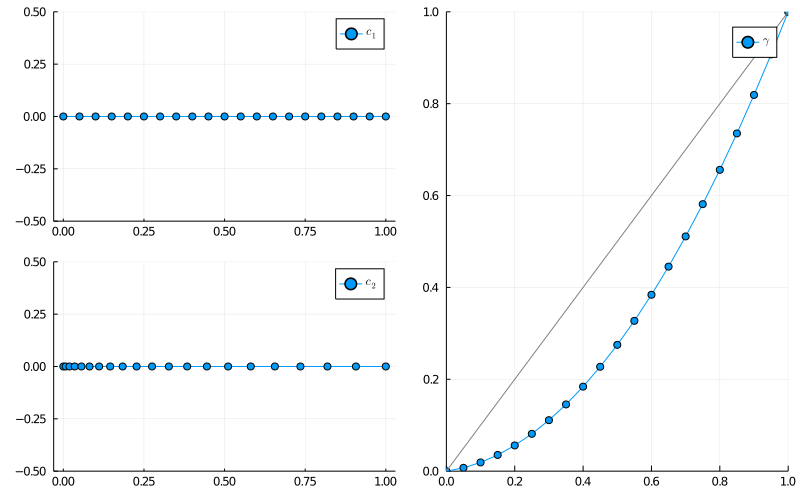

In [13]:
# Create grid of points to evaluate curves, and plot
X = 0:0.05:1
Xfine = 0:0.005:1


# Plot each of the curves, and collect into a single figure
p1 = plot_curve(c1, X, shape=:circle, ylims=(-0.5, 0.5), label="\$c_1\$")
p2 = plot_curve(c2, X, shape=:circle, ylims=(-0.5, 0.5), label="\$c_2\$")
p3 = plot(γopt, X, shape=:circle, label="\$\\gamma\$")
plot!(x -> x, X, width=1., color=:grey, xlims=(0,1), ylims=(0,1), label=:none)

# Collect and plot as a single figure
l = @layout [[a;b] c]
plot(p1, p2, p3, layout=l, size=(800, 500))

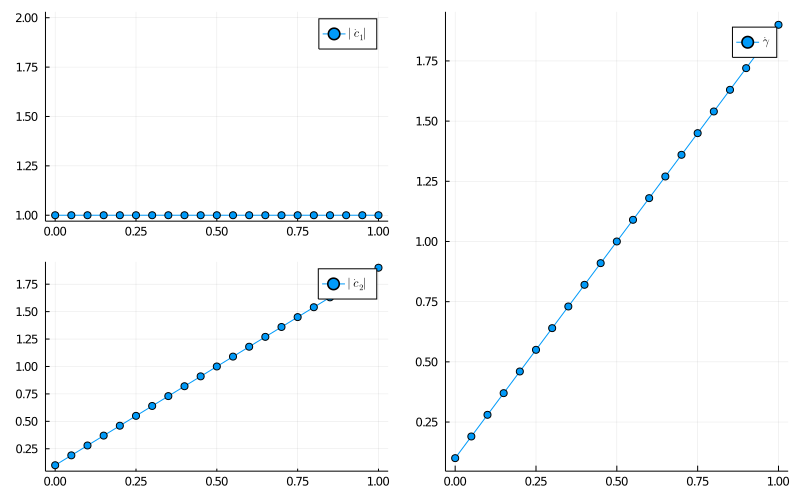

In [14]:
# Plot each of the curves, and collect into a single figure
p1 = plot(x -> norm(c1dt(x)), X, shape=:circle, label="\$|\\dot c_1|\$")
p2 = plot(x -> norm(c2dt(x)), X, shape=:circle, label="\$|\\dot c_2|\$")
p3 = plot(γoptdt, X, shape=:circle, label="\$\\dot \\gamma\$")

l = @layout[[a;b] c]

plot(p1, p2, p3, layout=l, size=(800, 500))

## Q-Transform 

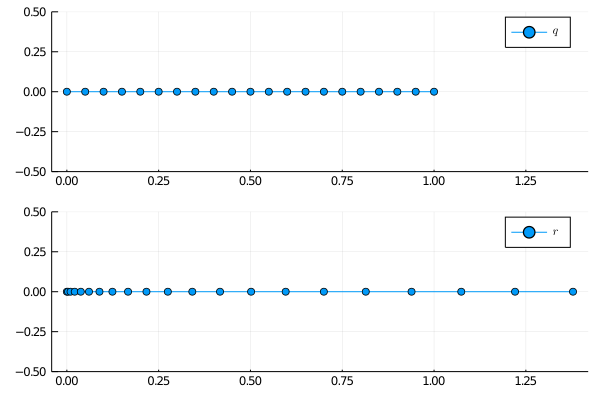

In [15]:
# Assert that the q-transform is properly implemented (by checking composition)
@test all(r.(X) ≈ (x -> sqrt(γoptdt(x)) * q(γopt(x))).(X))


# Plot each of the curves, and collect into a single figure
p1 = plot_curve(q, X, shape=:circle, ylims=(-0.5, 0.5), label="\$q\$")
p2 = plot_curve(r, X, shape=:circle, ylims=(-0.5, 0.5), label="\$r\$")
plot(p1, p2, layout=(2,1), link =:x)

## Various Approaches for Gradient Interpolation

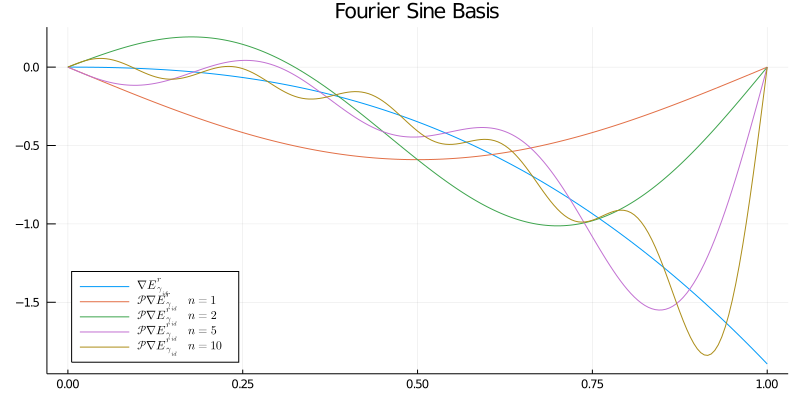

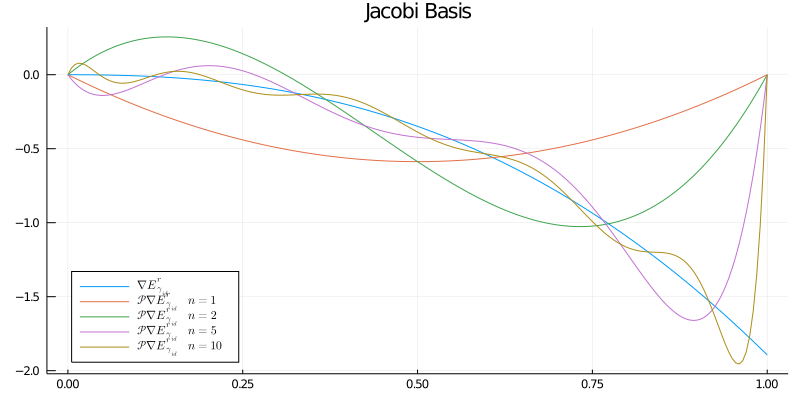

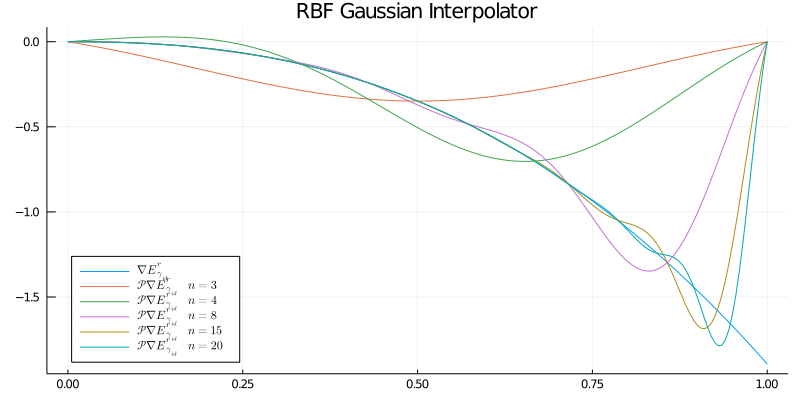

In [16]:
# Plot the gradient, and the projections with fourier basis
p = plot(∇E, Xfine, label="\$\\nabla E^r_{\\gamma_{id}}\$", size=(800, 400), title="Fourier Sine Basis")
for N in [1, 2, 5, 10]
    projE = project(∇E, FourierSineProjector(N))
    plot!(Xfine, projE.(Xfine), label="\$\\mathcal{ P }\\nabla E^r_{\\gamma_{id}}\\quad n=$N\$", legend=:bottomleft)
end
display(p)

# Plot the gradient, and the projection with Jacobi basis
p = plot(∇E, Xfine, label="\$\\nabla E^r_{\\gamma_{id}}\$", size=(800, 400), title="Jacobi Basis")
for N in [1, 2, 5, 10]
    projE = project(∇E, JacobiProjector(N))
    plot!(Xfine, projE.(Xfine), label="\$\\mathcal{ P }\\nabla E^r_{\\gamma_{id}}\\quad n=$N\$", legend=:bottomleft)
end
display(p)

# Plot the gradient, and the projection with RBF basis
p = plot(∇E, Xfine, label="\$\\nabla E^r_{\\gamma_{id}}\$", size=(800, 400), title="RBF Gaussian Interpolator")
for N in [3, 4, 8, 15, 20]
    interpE = project(∇E, GaussianInterpolationProjector(N))
    plot!(Xfine, interpE.(Xfine), label="\$\\mathcal{ P }\\nabla E^r_{\\gamma_{id}}\\quad n=$N\$", legend=:bottomleft)
end
display(p)

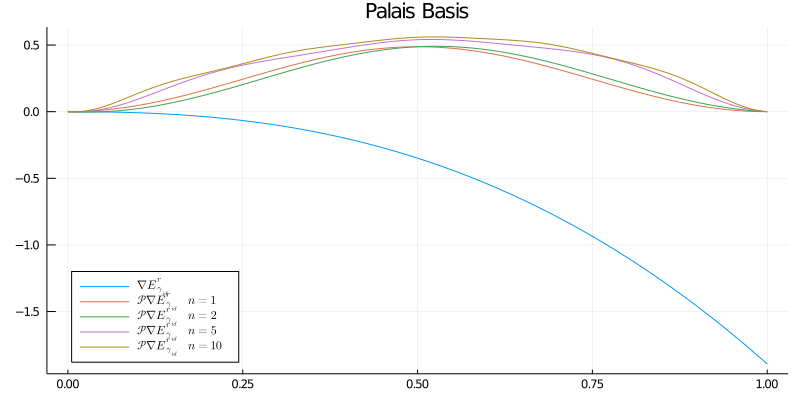

In [17]:
∇E = l2_gradient(q, r)
# Plot the gradient, and the projections with fourier basis
p = plot(∇E, Xfine, label="\$\\nabla E^r_{\\gamma_{id}}\$", size=(800, 400), title="Palais Basis")
for N in [1, 2, 5, 10]
    projE = project(∇E, PalaisProjector(N))
    plot!(Xfine, projE.(Xfine), label="\$\\mathcal{ P }\\nabla E^r_{\\gamma_{id}}\\quad n=$N\$", legend=:bottomleft)
end
display(p)

### Error Comparison for Various Interpolation Approaches

  1.540874 seconds (4.87 M allocations: 304.662 MiB, 4.19% gc time)
  0.132064 seconds (466.18 k allocations: 28.967 MiB)
  0.080519 seconds (256.33 k allocations: 16.200 MiB)


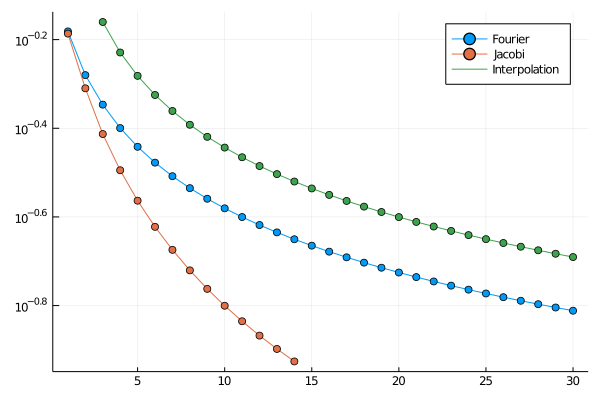

In [18]:
function projection_error_fourier(f, nmax)
    error = Array{Float64}(undef, nmax)
    for N in 1:nmax
        projf = project(f, FourierSineProjector(N))
        error[N] = l2_distance(f, projf)
    end
    return error
end


function projection_error_jacobi(f, nmax)
    error = Array{Float64}(undef, nmax)
    for N in 1:nmax
        projf = project(f, JacobiProjector(N))
        error[N] = l2_distance(f, projf)
    end
    return error
end

function interpolation_error_gaussian(f, nmax)
    error = Array{Float64}(undef, nmax)
    error[1:2] .= NaN
    for N in 3:nmax
        interpf = project(f, GaussianInterpolationProjector(N))
        error[N] = l2_distance(f, interpf)
    end
    return error
end


projection_error_fourier(∇E, 2)
projection_error_jacobi(∇E, 2)
interpolation_error_gaussian(∇E, 3)

@time error_fourier = projection_error_fourier(∇E, 30)
plot(error_fourier, shape=:circle, label="Fourier", yscale=:log10)

@time error_jacobi = projection_error_jacobi(∇E, 14)
plot!(error_jacobi, shape=:circle, label="Jacobi")

@time error_interp = interpolation_error_gaussian(∇E, 30)
plot!(error_interp, shape=:circle, label="Interpolation")

## Putting it All Together

In [19]:
module dev
include("src/projection.jl")
include("src/functionals.jl")
function nans(len::Int)
    out = Vector{Float64}(undef, len)
    for i in 1:len
        out[i] = NaN
    end
    out
end


struct ReparametrizationSolution{T1<:Function, T2<:Function, TP<:AbstractProjector}
    q::T1
    r::T2
    projector::TP
    errors::Vector{Float64}
    reparams::Vector{Function}
    maxiter::Int
    
    function ReparametrizationSolution(q::T1, r::T2, projector::TP, maxiter::Int) where {T1<:Function, T2<:Function, TP<:AbstractProjector}
        errors = nans(maxiter+1)
        reparams = Vector{Function}(undef, maxiter+1)
        new{T1, T2, TP}(q, r, projector, errors, reparams, maxiter)
    end
end
end #module

Main.dev

In [20]:
function nans(len::Int)
    out = Vector{Float64}(undef, len)
    for i in 1:len
        out[i] = NaN
    end
    out
end

nans (generic function with 1 method)

In [21]:
struct ReparametrizationSolution{T1<:Function, T2<:Function, TP<:AbstractProjector}
    q::T1
    r::T2
    projector::TP
    errors::Vector{Float64}
    reparams::Vector{Function}
    maxiter::Int
    
    function ReparametrizationSolution(q::T1, r::T2, projector::TP, maxiter::Int) where {T1<:Function, T2<:Function, TP<:AbstractProjector}
        errors = nans(maxiter+1)
        reparams = Vector{Function}(undef, maxiter+1)
        new{T1, T2, TP}(q, r, projector, errors, reparams, maxiter)
    end
end

In [22]:
function accumulate_composition(funcvec)
    n = length(funcvec)
    out = Vector{Function}(undef, n)
    out[1] = funcvec[1]
    for i in 2:n
        out[i] = out[i-1] ∘ funcvec[i]
    end
    return out
end

accumulate_composition (generic function with 1 method)

## Reparametrization Plots

In [37]:
function plot_parametrization(γ, γ_composite; opt=nothing, npoints=201, title="")
    X = range(0, 1, length=npoints)
    p = plot(γ, X, label="γ", color="red", legend=:topleft, width=0.3, title=title)
    
    plot!(γ_composite, X, label="Composed", color="blue")
    if !(opt === nothing) 
        plot!(opt, X, ls=:dash, color=:black, label="Optimal")
    end
    p
end

function plot_parametrization(res::ReparametrizationSolution, n::Int; opt=nothing, npoints=201, title="")
    fv = accumulate_composition(res.reparams)
    plot_parametrization(res.reparams[n], fv[n], opt=opt, npoints=npoints, title=title)
end


function plot_qmaps(q1, q2; npoints_coarse=31, npoints_fine=201, title="")
    Xcoarse = range(0, 1, length=npoints_coarse)
    Xfine = range(0, 1, length=npoints_fine)
    
    p = plot_curve(q1, Xfine, label="q", color=:red, title=title)
    plot_curve!(q1, Xcoarse, color=:red, seriestype=:scatter, label="")
    
    plot_curve!(q2, Xfine, label="r", color=:blue, title=title)
    plot_curve!(q2, Xcoarse, color=:blue, seriestype=:scatter, label="")
end

function plot_qmaps(res::ReparametrizationSolution, n::Int; npoints_coarse=31, npoints_fine=401, title="")
    fv = accumulate_composition(res.reparams)
    plot_qmaps(res.q, Q_reparametrization(res.r, fv[n]), npoints_coarse=npoints_coarse, npoints_fine=npoints_fine,
                title=title)
end


function plot_gradient(res::ReparametrizationSolution, n::Int; npoints=401, kwargs...)
    X = range(0, 1, length=npoints)
    
    fv = accumulate_composition(res.reparams)
    
    ∇E = l2_gradient(res.q, Q_reparametrization(res.r, fv[n]))
    dγ = project(∇E, res.projector)
    
    
    plot(∇E, X, label="∇E"; kwargs...)
    plot!(X, dγ.(X); label="δγ", kwargs...)
end

function plot_reparam_iter(res::ReparametrizationSolution, n::Int; opt=nothing, coarse=31, fine=401)
    Xcoarse = range(0, 1, length=coarse)
    Xfine = range(0, 1, length=fine)
    
    # Plot Diffeomorphisms
    p1 = plot_parametrization(res,  n, opt=opt, npoints=fine, title="Diffeomorphsisms: Iter $n")
    p2 = plot_qmaps(res, n, npoints_coarse=coarse, npoints_fine=fine, title="Q-maps")
    p3 = plot_gradient(res, n, npoints=fine, title="Gradient")
    p4 = plot(res.errors[1:n+1] / res.errors[1], shape=:circle, title="Relative Error", legend=false, yscale=:log10)
    return plot(p1, p2, p3, p4, layout=@layout[a b; c d], size=(800, 600))
end

function create_reparam_animation(res::ReparametrizationSolution; opt=nothing, savename="tmp.gif", fps=2)
    plots = []
    for i in 1:res.maxiter
        push!(plots, plot_reparam_iter(res, i, opt=opt))
    end

    anim = @animate for p in plots
        plot(p)
    end

    gif(anim, savename, fps=fps)
end

create_reparam_animation (generic function with 1 method)

In [71]:
function reparametrize(q, r, projector::T; maxiter=20, tol=10, verbosity=0) where {T <: AbstractProjector}
    @assert maxiter > 0

    id(x) = x
    ψ = id    
    
    res = ReparametrizationSolution(q, r, projector, maxiter)
    res.errors[1] = l2_distance(q, r)^2
    res.reparams[1] = id
    
    if verbosity == 1
        printheader()
        printfirst(l2_distance(q, r)^2)
    end
    
    ψ = id    
    for i in 1:maxiter
        ∇E = l2_gradient(q, r)
        dγ = project(∇E, projector) #, min(projector.dim, i))
                
        εmax = max_step_length(dγ, alpha=0.999)
        ε = εmax * 0.5^i

        ε = backtracking(q, r, dγ, εmax , ρ=0.9, c=0.8, verbose=(verbosity >= 2), maxiter=300)
        
        dγ.W .*= ε
        γ(x) = x - dγ(x)
        r = Q_reparametrization(r, γ)
        ψ = ψ ∘ γ
        res.errors[i+1] = l2_distance(q, r)^2
        res.reparams[i+1] = γ
        printline(i, l2_distance(q, r)^2, εmax, ε, l2_norm(dγ), relative_error(res.errors[i+1], res.errors[i]))
    end
    
    if verbosity >= 1
        printfooter()
    end
    return res
end

reparametrize (generic function with 1 method)

 ----------------------------------------------------------------------------------
| Iter | Error            | εmax             | εi               | ||dγ||           | |f_i - f_{i-1}|/ |fi| | 
----------------------------------------------------------------------------------
|    0 | 6.3185650397e+00 |                  |                  |                  |
|    1 | 2.4784912204e+00 | 2.7516990994e-03 | 9.5945814961e-04 | 6.7445786134e-02 | 6.0774460581e-01 |
|    2 | 1.2380865526e+00 | 4.9277288677e-03 | 9.1311810770e-04 | 3.7326926097e-02 | 5.0046764645e-01 |
|    3 | 9.7196916706e-01 | 1.7769231148e-03 | 4.0650301306e-04 | 1.1573715408e-02 | 2.1494247308e-01 |
|    4 | 8.2666602472e-01 | 1.1100848113e-03 | 2.8216866483e-04 | 7.1434543149e-03 | 1.4949357168e-01 |
|    5 | 6.8241078524e-01 | 1.9690534832e-03 | 3.6486958574e-04 | 8.0491094314e-03 | 1.7450244133e-01 |
|    6 | 6.0159833239e-01 | 1.2695644441e-03 | 2.3525285460e-04 | 4.8562924773e-03 | 1.1842200416e-01 |
|    7 | 4.704

┌ Info: Saved animation to 
│   fn = /home/jorgen/.julia/dev/Reparam/fourier10.gif
└ @ Plots /home/jorgen/.julia/packages/Plots/4EfKl/src/animation.jl:104


Plots.AnimatedGif("/home/jorgen/.julia/dev/Reparam/fourier10.gif")
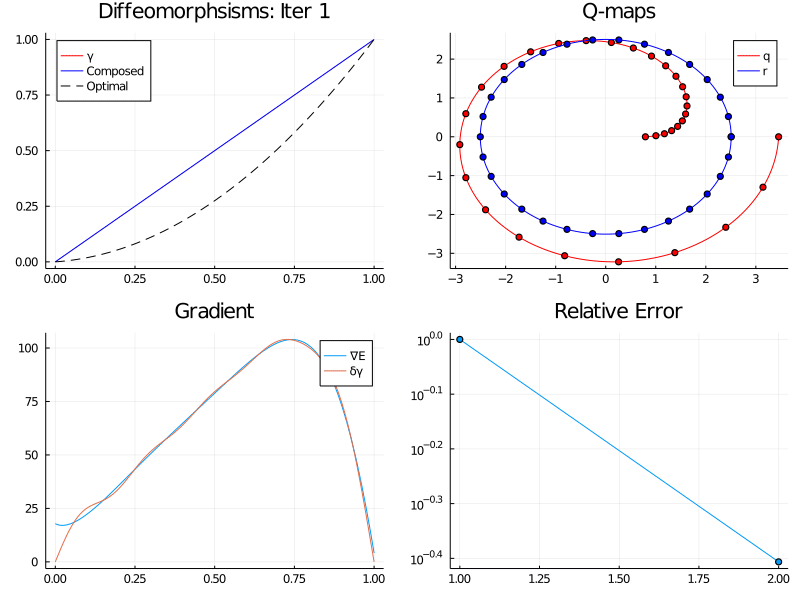

In [72]:
s1(t) = [cos(2π*t), sin(2π*t)]
s2 = s1 ∘ γopt

q = Q_transform(s1)
r = Q_transform(s2)

res = reparametrize(r, q, FourierSineProjector(10), maxiter=30, verbosity=1);
create_reparam_animation(res, savename="fourier10.gif", opt=γopt)

 ----------------------------------------------------------------------------------
| Iter | Error            | εmax             | εi               | ||dγ||           | |f_i - f_{i-1}|/ |fi| | 
----------------------------------------------------------------------------------
|    0 | 6.3185650397e+00 |                  |                  |                  |
|    1 | 2.8029159032e+00 | 8.5358699239e-04 | 8.5358699239e-04 | 6.0026881328e-02 | 5.5639992853e-01 |
|    2 | 1.5559033554e+00 | 1.1805478414e-03 | 7.7455743876e-04 | 3.4569291066e-02 | 4.4489830977e-01 |
|    3 | 1.4678303139e+00 | 3.6688606471e-04 | 6.7984728492e-05 | 2.7272595043e-03 | 5.6605727607e-02 |
|    4 | 1.0943243322e+00 | 4.7999810946e-04 | 4.7999810946e-04 | 1.4558595284e-02 | 2.5446128083e-01 |
|    5 | 1.0412016680e+00 | 1.6611393894e-04 | 7.9451782042e-05 | 2.2926821541e-03 | 4.8543802450e-02 |
|    6 | 9.3065419965e-01 | 9.3314676852e-04 | 2.1347404953e-04 | 5.4199045222e-03 | 1.0617296509e-01 |
|    7 | 9.008

┌ Info: Saved animation to 
│   fn = /home/jorgen/.julia/dev/Reparam/jacobi2_10.gif
└ @ Plots /home/jorgen/.julia/packages/Plots/4EfKl/src/animation.jl:104


Plots.AnimatedGif("/home/jorgen/.julia/dev/Reparam/jacobi2_10.gif")
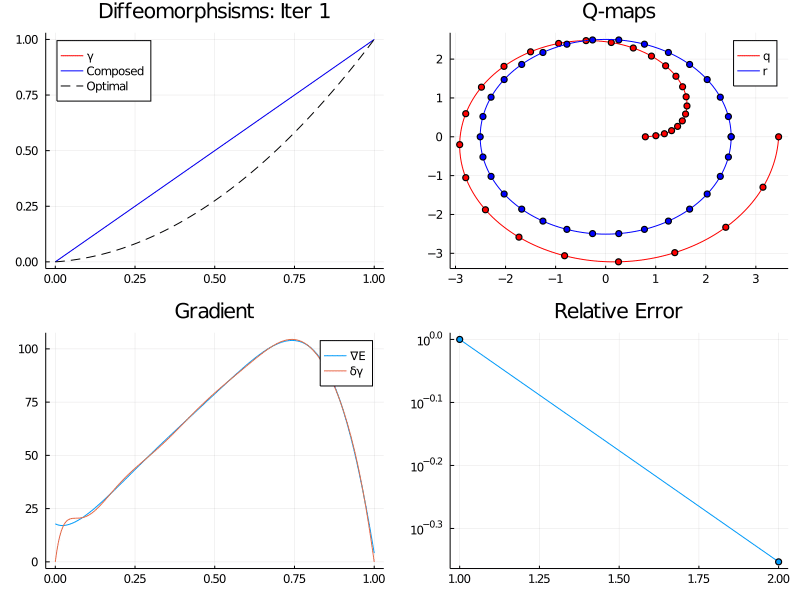

In [73]:
s1(t) = [cos(2π*t), sin(2π*t)]
s2 = s1 ∘ γopt

res = reparametrize(r, q, JacobiProjector(10), maxiter=30, verbosity=1);
create_reparam_animation(res, savename="jacobi2_10.gif", opt=γopt)

 ----------------------------------------------------------------------------------
| Iter | Error            | εmax             | εi               | ||dγ||           |
----------------------------------------------------------------------------------
|    0 | 6.3185650397e+00 |                  |                  |                  |
|    1 | 4.3007565807e+00 | 4.9566655002e-03 | 4.0148990552e-03 | 5.5379365412e+01 |
|    2 | 3.3532439246e+00 | 1.8364327007e-04 | 1.8364327007e-04 | 1.4776705885e+02 |
|    3 | 2.8274244797e+00 | 1.3189608032e-04 | 1.3189608032e-04 | 1.2457520631e+02 |
|    4 | 1.9531439322e+00 | 4.2042960448e-04 | 3.0649318167e-04 | 1.5083229364e+02 |
|    5 | 1.7806601321e+00 | 1.8208264050e-04 | 4.1654667764e-05 | 1.9909925382e+02 |
[backtracking] Warning: Couldn't find sufficient decrease stepsize in 300 steps.
|    6 | 1.7806601321e+00 | 1.7829857898e-04 | 3.3411864672e-18 | 2.8209709983e+02 |
[backtracking] Warning: Couldn't find sufficient decrease stepsize in 30

┌ Info: Saved animation to 
│   fn = /home/jorgen/.julia/dev/Reparam/palais10.gif
└ @ Plots /home/jorgen/.julia/packages/Plots/4EfKl/src/animation.jl:104


Plots.AnimatedGif("/home/jorgen/.julia/dev/Reparam/palais10.gif")
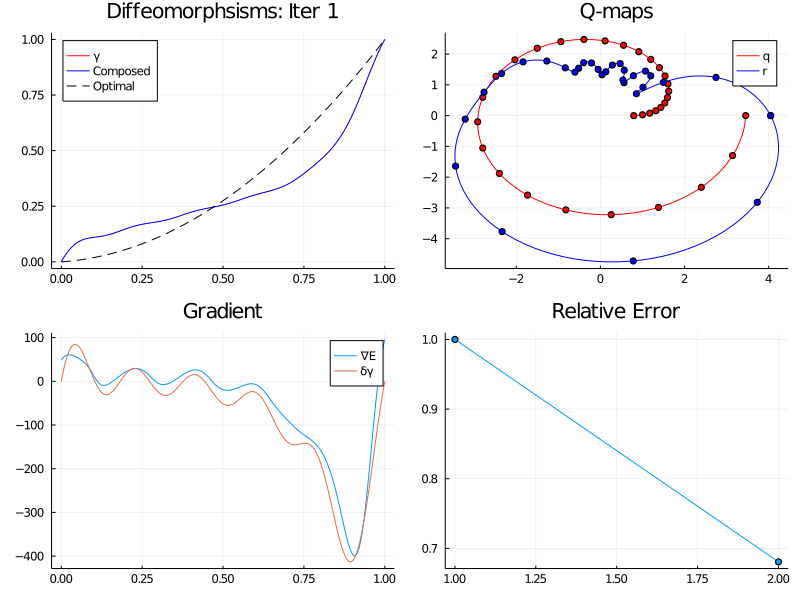

In [25]:
s1(t) = [cos(2π*t), sin(2π*t)]
s2 = s1 ∘ γopt

q = Q_transform(s1)
r = Q_transform(s2)

res = reparametrize(r, q, PalaisProjector(10), maxiter=10, verbosity=1);
create_reparam_animation(res, savename="palais10.gif", opt=γopt)

 ----------------------------------------------------------------------------------
| Iter | Error            | εmax             | εi               | ||dγ||           | |f_i - f_{i-1}|/ |fi| | 
----------------------------------------------------------------------------------
|    0 | 6.3185650397e+00 |                  |                  |                  |
|    1 | 2.6214291193e+00 | 1.7158734312e-03 | 9.1188549217e-04 | 6.4088872028e-02 | 5.8512271333e-01 |
|    2 | 2.1997891974e+00 | 5.3261381344e-04 | 2.8305281763e-04 | 1.2114620310e-02 | 1.6084353333e-01 |
|    3 | 2.1629381286e+00 | 5.9120404096e-05 | 9.8596172126e-06 | 6.7326091830e-04 | 1.6752090985e-02 |
|    4 | 2.0875637941e+00 | 1.2896509274e-04 | 4.0470612628e-05 | 1.9254377936e-03 | 3.4848123258e-02 |
[backtracking] Warning: Couldn't find sufficient decrease stepsize in 300 steps.
|    5 | 2.0875637941e+00 | 1.4049889597e-04 | 2.6328477352e-18 | 1.2828777787e-16 | 1.4891159148e-15 |
[backtracking] Warning: Couldn't find

┌ Info: Saved animation to 
│   fn = /home/jorgen/.julia/dev/Reparam/gauss30.gif
└ @ Plots /home/jorgen/.julia/packages/Plots/4EfKl/src/animation.jl:104


Plots.AnimatedGif("/home/jorgen/.julia/dev/Reparam/gauss30.gif")
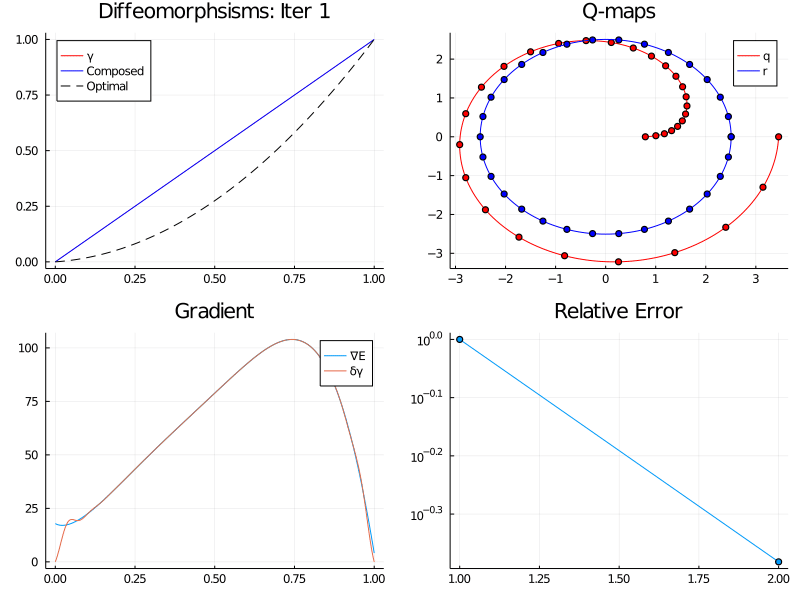

In [79]:
s1(t) = [cos(2π*t), sin(2π*t)]
s2 = s1 ∘ γopt

q = Q_transform(s1)
r = Q_transform(s2)

res = reparametrize(r, q, GaussianInterpolationProjector(30), maxiter=10, verbosity=1);
create_reparam_animation(res, savename="gauss30.gif", opt=γopt)